# Creating a U-net for Cellular Segmentation by Jamil Gafur

<ol>
    <li>Lets load in the imports, we will be using Keras layers to create the U-net</li>
    <li>now we have some gloabl variables, lets discuss this more in detail</li>
    <ul>
        <li>image_location: the directory of where the test and training data is located</li>
        <li>image: the training images</li>
        <li>label: the training output</li>
        <li>test: location of the test data</li>
    </ul>
</ol>

In [1]:
from __future__ import print_function

from matplotlib import pyplot as plt
from keras import losses
import os
from keras.models import Model
from keras.layers import Input, concatenate, Conv2D, MaxPooling2D, Conv2DTranspose
from keras.optimizers import Adam
import cv2
import numpy as np
# training data 
image_location = "C:/Users/Jamil/Desktop/Code/Python/Unet/"
image = image_location+"train/image"
label = image_location +"train/label"
test = image_location +"test"


Using TensorFlow backend.


Lets create a data structure for easy access to the training data
<ul>
<li>__init__ : takes in the location of the training image (image), takes in the location of the training output (label) </li>
<li>get_images(): returns a numpy array of the images</li>
<li>get_label(): returns a numpy array of the output</li>
</ul>

In [16]:
class train_data():
    
    def __init__(self, image, label):
        self.image = []
        self.label = []
        for file in os.listdir(image):
            if file.endswith(".tif"):
                self.image.append(cv2.imread(image+"/"+file,0))
        
        for file in os.listdir(label):
            if file.endswith(".tif"):
                #print(label+"/"+file)
                self.label.append(cv2.imread(label+"/"+file,0))
    
    def get_image(self):
        return np.array(self.image)
    
    def get_label(self):
        return np.array(self.label)
    
    def set_image(self, new_images):
        self.image = new_image
    
    def set_label(self,new_label):
        self.label = new_label

Lets create a data structure for easy access to the test data
<ul>
<li>__init__ : takes in the location of the test image (image) </li>
<li>get_data(): returns a numpy array of the test images</li>
</ul>

In [3]:
class test_data():
    
    def __init__(self, test):
        self.test_Images = []
        for file in os.listdir(test):
            if file.endswith(".tif"):
                self.test_Images.append(cv2.imread(image+"/"+file,0))

    def get_data(self):
        return np.array(self.test_Images)


design the Unet Code used fromt 

https://github.com/jocicmarko/ultrasound-nerve-segmentation/blob/master/train.py; with slight modification

In [4]:

def get_unet(rows, cols):
    inputs = Input((rows, cols, 1))
    print("Input  : " + str(inputs))
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(pool1)
    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool2)
    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(pool3)
    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)

    conv5 = Conv2D(512, (3, 3), activation='relu', padding='same')(pool4)
    conv5 = Conv2D(512, (3, 3), activation='relu', padding='same')(conv5)

    up6 = concatenate([Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(conv5), conv4], axis=3)
    conv6 = Conv2D(256, (3, 3), activation='relu', padding='same')(up6)
    conv6 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv6)

    up7 = concatenate([Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(conv6), conv3], axis=3)
    conv7 = Conv2D(128, (3, 3), activation='relu', padding='same')(up7)
    conv7 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv7)

    up8 = concatenate([Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(conv7), conv2], axis=3)
    conv8 = Conv2D(64, (3, 3), activation='relu', padding='same')(up8)
    conv8 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv8)

    up9 = concatenate([Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(conv8), conv1], axis=3)
    conv9 = Conv2D(32, (3, 3), activation='relu', padding='same')(up9)
    conv9 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv9)

    conv10 = Conv2D(1, (1, 1), activation='sigmoid')(conv9)
    print("Output : " + str(conv10))
    model = Model(inputs=[inputs], outputs=[conv10])

    model.compile(optimizer=Adam(lr=1e-5), loss = losses.mean_squared_error)

    return model



### First we will load in all the data

In [5]:
train_set = train_data(image, label)
test_set = test_data(test)

# We would like to deform the images in the train set to get a larger amount of images for training.
<ol style="color:red;">
    <li>we first would create a deformation program that takes an image and another parameter(not known yet) and   deform the image.</li>
    <li>then we will iterate through the images, and there respected label 
 for every image and label deform it n times and add that to a list</li>
    <li>set new list with all images (deformed and original)</li>
    <li>train</li>
   </ol>

In [7]:
train_images = train_set.get_image()
train_label = train_set.get_label()

test_info = test_set.get_data()

### Now we will create the U-Net 

In [8]:
unet = get_unet(train_label[0].shape[0],train_label[0].shape[1])

Input  : Tensor("input_1:0", shape=(?, 512, 512, 1), dtype=float32)
Output : Tensor("conv2d_19/Sigmoid:0", shape=(?, 512, 512, 1), dtype=float32)


### Now we will reshape the images so it is compatible with the U-net


<p style="color:red;"> error might exist because of this, will need to test further </p>

In [9]:
   
train_images = train_images.reshape(30,512,512,1)
train_label = train_label.reshape(30,512,512,1)

In [10]:
print("reshape:-------------------------\n\n")
print("type of train_images" + str(type(train_images[0])))
print("type of train_label" + str(type(train_label[0])))
print('\n')
print("shape of train_images" + str(train_images.shape))
print("shape of train_label" + str(train_label.shape))
print('\n')
print("shape of train_images[0]" + str(train_images[0].shape))
print("shape of train_label[0]" + str(train_label[0].shape))


reshape:-------------------------


type of train_images<class 'numpy.ndarray'>
type of train_label<class 'numpy.ndarray'>


shape of train_images(30, 512, 512, 1)
shape of train_label(30, 512, 512, 1)


shape of train_images[0](512, 512, 1)
shape of train_label[0](512, 512, 1)


### here is an example of the training data input

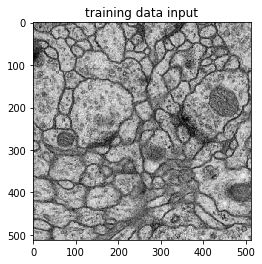

In [11]:
plt.imshow(train_images[0].reshape(512,512), interpolation='nearest', cmap='gray')
plt.title("training data input")
plt.show()
    

### Here is an example of the training data output

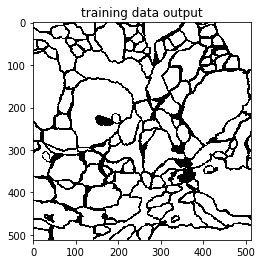

In [12]:
plt.imshow(train_label[0].reshape(512,512), interpolation='nearest', cmap='gray')
plt.title("training data output")
plt.show()

### We will load in the pretrained network (if you want to start over comment this out)

In [13]:
#unet.load_weights('Unet.h5')

### I am running everything on a CPU, so I run 1 epoch multiple times and save the data 

In [14]:
for i in range(1):
    unet.fit(train_images, train_label, validation_data=
      (train_images, train_label), epochs=1, batch_size=1)
    unet.save('Unet.h5')

Train on 30 samples, validate on 30 samples
Epoch 1/1
30/30 [==============================] - 17s - loss: 50417.7845 - val_loss: 50369.5667


### Here is an example of the test input

(30, 512, 512)


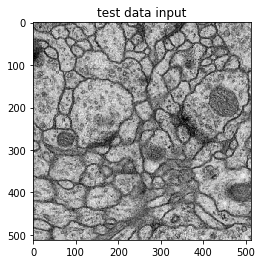

In [32]:
print(test_info.shape)
plt.imshow(test_info[0].reshape(512,512), interpolation='nearest', cmap='gray')
plt.title("test data input")
plt.show()

### now lets reshape the test data, just like we did with the input

In [33]:
test_info = test_info.reshape(30,512,512,1)
print(test_info.shape)
print(str(type(test_info)))


(30, 512, 512, 1)
<class 'numpy.ndarray'>


### we will now make a prediction

In [35]:
prediction = unet.predict(test_info, batch_size =1)

### This is the information for the prediction

In [36]:
print("prediction shape: " + str(prediction.shape))
print(str(type(prediction)))
print("prediction[0] shape: " + str(prediction[0].shape))

prediction shape: (30, 512, 512, 1)
<class 'numpy.ndarray'>
prediction[0] shape: (512, 512, 1)


### now we will show what the prediction for the first input was

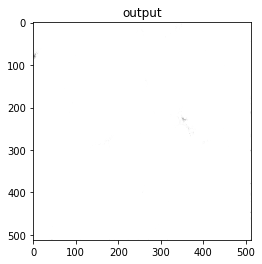

In [37]:
test_label = prediction[0]
test_label = test_label.reshape(512,512)
plt.imshow(test_label ,cmap='gray')
plt.title("output")
plt.show()

<h2 style = "color:red">As you continue to train it, the output seems to phase towards a singular color and segmentation seems to not work</h2>

#### let us check to see what is happening the the input and output of the test data
<ol>
<li>first we will check the difference between the test input vs the test output</li>
<li>Then we will overlap them to see where it overlaps</li>
</ol>

In [38]:
Test_Input = test_info[0]
print(str(Test_Input.shape))
Test_Input = Test_Input.reshape(512,512)

(512, 512, 1)


In [39]:
Test_Output = prediction[0]
print(str(Test_Output.shape))
Test_Output = Test_Output.reshape(512,512)

(512, 512, 1)


In [40]:
difference = 0

for i in range(test_info.shape[0]):
    for j in range(test_info.shape[0]):
        difference = Test_Input[i][j] - Test_Output[i][j]
        
        
print(str(difference))

170.0


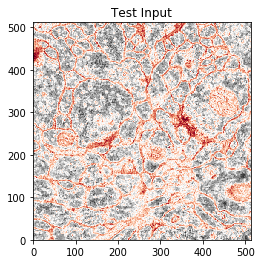

In [41]:
extent = 0, 512, 0, 512
plt.imshow(Test_Input, cmap='RdGy', interpolation='nearest',
                 extent=extent)
plt.title("Test Input")
plt.show()


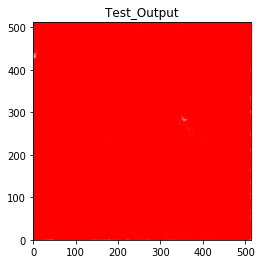

In [42]:
plt.imshow(Test_Output, cmap='bwr',interpolation='bilinear',
                 extent=extent)
plt.title("Test_Output")
plt.show()


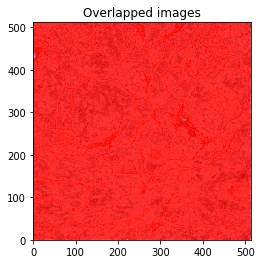

In [43]:
plt.imshow(Test_Input, cmap='RdGy', interpolation='nearest',
                 extent=extent)
plt.imshow(Test_Output, cmap='bwr', alpha=.8, interpolation='bilinear',
                 extent=extent)
plt.title("Overlapped images")
plt.show()
plt.show()